# This notebook gives 
## X_train, y_train
## X_val, y_val
## X_test

In [1]:
import pandas as pd
import numpy as np

import math
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing 
from scipy.optimize import minimize
from sklearn import metrics

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from datetime import datetime
import nltk
#nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords



In [3]:
train = pd.read_csv('train.csv')
val = pd.read_csv('dev.csv')
test = pd.read_csv('test_no_label.csv').drop('label', axis = 1)

In [4]:
print("Training data:   ", train.shape)
print("Validation data: ", val.shape)
print("Test data:       ", test.shape)  # no label


Training data:    (250874, 7)
Validation data:  (35918, 7)
Test data:        (72165, 6)


In [5]:
train.head(10)

,ex_id,user_id,prod_id,rating,label,date,review
0,0,923,0,3.0,1,2014-12-08,The food at snack is a selection of popular Gr...
1,1,924,0,3.0,1,2013-05-16,This little place in Soho is wonderful. I had ...
2,2,925,0,4.0,1,2013-07-01,ordered lunch for 15 from Snack last Friday. ...
3,3,926,0,4.0,1,2011-07-28,This is a beautiful quaint little restaurant o...
4,4,927,0,4.0,1,2010-11-01,Snack is great place for a casual sit down lu...
5,5,928,0,4.0,1,2009-09-02,A solid 4 stars for this greek food spot. If ...
6,7,930,0,4.0,1,2007-05-20,Love this place! Try the Chicken sandwich or ...
7,8,931,0,4.0,1,2005-12-27,My friend and I were intrigued by the nightly ...
8,10,933,0,5.0,1,2014-01-21,pretty cool place...good food...good people
9,12,935,0,5.0,1,2011-01-31,Fabulous Authentic Greek Food!!! This little s...


## TF-IDF Vectorization

In [6]:
train_corpus = train['review']
val_corpus = val['review']
test_corpus=test['review']

In [7]:
tf = TfidfVectorizer(binary = False, ngram_range = (1,2), stop_words = 'english',min_df=0.01,max_df=0.3)

In [8]:
train_tfidf = tf.fit_transform(train_corpus)

In [9]:
print(train_tfidf.shape)

(250874, 923)


In [10]:
print(type(train_tfidf))

<class 'scipy.sparse.csr.csr_matrix'>


In [11]:
train_features=train_tfidf.toarray()   #convert to numpy array

In [12]:
val_tfidf=tf.transform(val_corpus)

In [13]:
val_features=val_tfidf.toarray()

In [14]:
val_features.shape

(35918, 923)

In [15]:
test_tfidf=tf.transform(test_corpus)

In [16]:
test_features=test_tfidf.toarray()

In [17]:
test_features.shape

(72165, 923)

###  Add the column for rating and divide by 5 to bring the value between [0,1]

In [19]:
X_train=np.c_[train_features,train['rating'].values/5] 

In [20]:
X_val=np.c_[val_features,val['rating'].values/5]

In [21]:
X_test=np.c_[test_features,test['rating'].values/5]

In [22]:
#X_val[:,-1][:10]*5 #check top 10

In [23]:
#X_test[:,-1][:10]*5 #check top 10

In [24]:
y_train = train['label'].values
y_val = val['label'].values

## Processed Data for Training, Validation and Testing:

In [25]:
print("Training data is ", X_train.shape, "and labels are ", y_train.shape)

Training data is  (250874, 924) and labels are  (250874,)


In [26]:
print("Validation data is ", X_val.shape, "and labels are ", y_val.shape)

Validation data is  (35918, 924) and labels are  (35918,)


In [27]:
print("Test data is ", X_test.shape, "and labels will be predicted by model ")

Test data is  (72165, 924) and labels will be predicted by model 


In [28]:
#np.savetxt('X_train.csv', X_train, delimiter=',')

In [29]:
#np.savetxt('y_val.csv', y_val)

## Reference:
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/

https://stackoverflow.com/questions/27697766/understanding-min-df-and-max-df-in-scikit-countvectorizer

## In Training set:
The fake reviews (+1) are 25819 and genuine reviews (0) are 225055 out of total 250874 samples. 
10.29 % fake reviews.

## In Validation set:
The fake reviews (+1) are 3648 and genuine reviews (0) are 32270 out of total 35918 samples.
10.16 % fake reviews.

# ---------------------------------------------------------------------------------------

## Model

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.naive_bayes import BernoulliNB


In [32]:
bnb_tv = BernoulliNB().fit(X_train,y_train).predict_proba(X_val)


In [33]:
fpr_bnb_tv, tpr_bnb_tv, thresholds_bnb_tv = metrics.roc_curve(y_val, bnb_tv[:,1])


In [34]:
roc_auc_bnb_tv = metrics.auc(fpr_bnb_tv, tpr_bnb_tv)
roc_auc_bnb_tv

0.6711586959535498

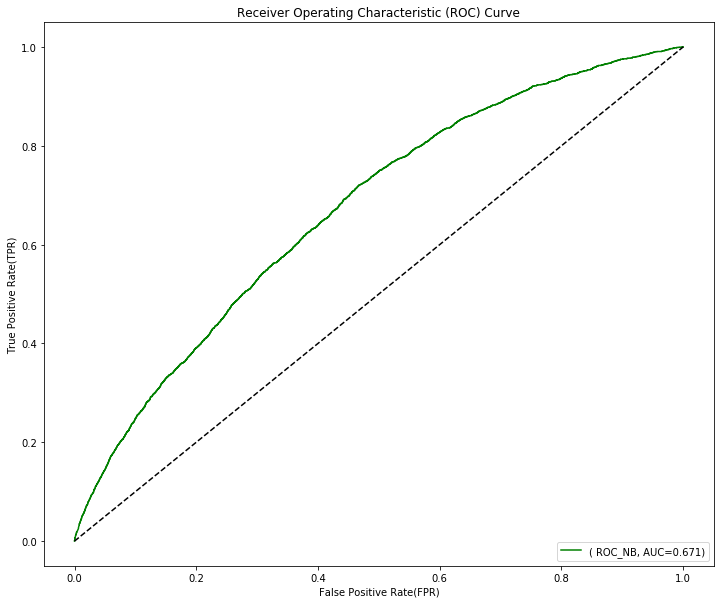

In [35]:
plt.figure(figsize=(12 ,10))
#plt.plot(fpr, tpr, color='red', label='( ROC_LR, AUC=%0.3f)'%auc)
plt.plot(fpr_bnb_tv, tpr_bnb_tv, color='Green', label='( ROC_NB, AUC=%0.3f)'%roc_auc_bnb_tv)

plt.plot([0, 1], [0, 1], color='Black', linestyle='--')
plt.xlabel('False Positive Rate(FPR)')
plt.ylabel('True Positive Rate(TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc=4) #4:lower right legend
